# Directed Sampling 


### initialising logging and notebook

In [95]:
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

In [96]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
!date
BABELDRAW=False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Fri Jun  9 13:12:43 BST 2017


### set up graph source

In [97]:
# get data
from eden.io.gspan import gspan_to_eden
from itertools import islice
import graphlearn.utils.draw as draw
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

dataset_fname = '../../toolsdata/bursi.pos.gspan'

def get_graphs():
    return get_graphs(dataset_fname)

In [98]:
from toolz import memoize, curry, pipe
from eden_chem.io.pubchem import download
download_active = curry(download)(active=True)
download_inactive = curry(download)(active=False)

from eden_chem.obabel import load as babel_load
from eden.util import timeit
@memoize
@timeit
def get_pos_graphs(assay_id):
    return pipe(assay_id, download_active, babel_load, list)

In [99]:
assay_id = '651610' #apr93 23k mols
assay_id = '1834'   #apr90 500 mols
assay_id = '624466' #apr88 p5k n23k
assay_id = '588350' #apr86 p1k n600
assay_id = '449764' #apr85
assay_id = '492952' #apr85
assay_id = '463112' #apr82
assay_id = '463213' #apr70
assay_id = '119'    #apr60 30k mols
assay_id = '1224857'#apr10
assay_id = '2326'   #apr03 200k mols

assay_id = '588350' #apr86 p1k n600

In [100]:
def get_graphs():
    return get_pos_graphs(assay_id)

### set up a scoring system :D 

In [101]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from eden.graph import Vectorizer

class VecComparator():
    def __init__(self, vector):
        self.base = vector 
    def __init__(self,graph, vectorizer):
        self.vectorizer=vectorizer
        self.base = self.vectorizer.transform([graph])[0]        
    def fit(self,ignore,**ignore2):
        pass
    def predict(self,vector):
        return 1/(1+euclidean_distances(self.base,vector)[0][0])

In [102]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

class VecComparator():
    def __init__(self, reference_vecs, desired_distances):
        self.reference_vecs = reference_vecs
        self.desired_distances = desired_distances
    def fit(self,ignore,**ignore2):
        pass
    def predict(self,vector):
        # compute the distance to each of the reference vectors
        distances = euclidean_distances(vector, self.reference_vecs)[0]
        # score the discrepancy w.r.t. the desired distances
        discrepancy = np.sum(np.abs(distances - self.desired_distances))
        # convert it to a similarity value to maximize
        similarity = 1/(1+discrepancy)
        return similarity

In [103]:
from eden.graph import Vectorizer
vec = Vectorizer(complexity=3, normalization=False, inner_normalization=False, n_jobs=1)
vec = Vectorizer(complexity=3, n_jobs=1)

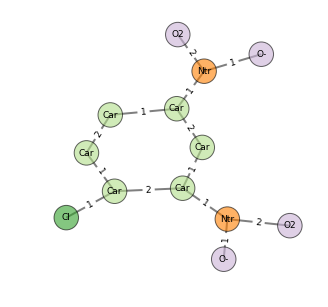

id:1041 (0.97) id:564 (1.00) id:670 (1.04) id:677 (1.06) id:441 (1.06) id:671 (1.07) id:927 (1.07) id:525 (1.08)

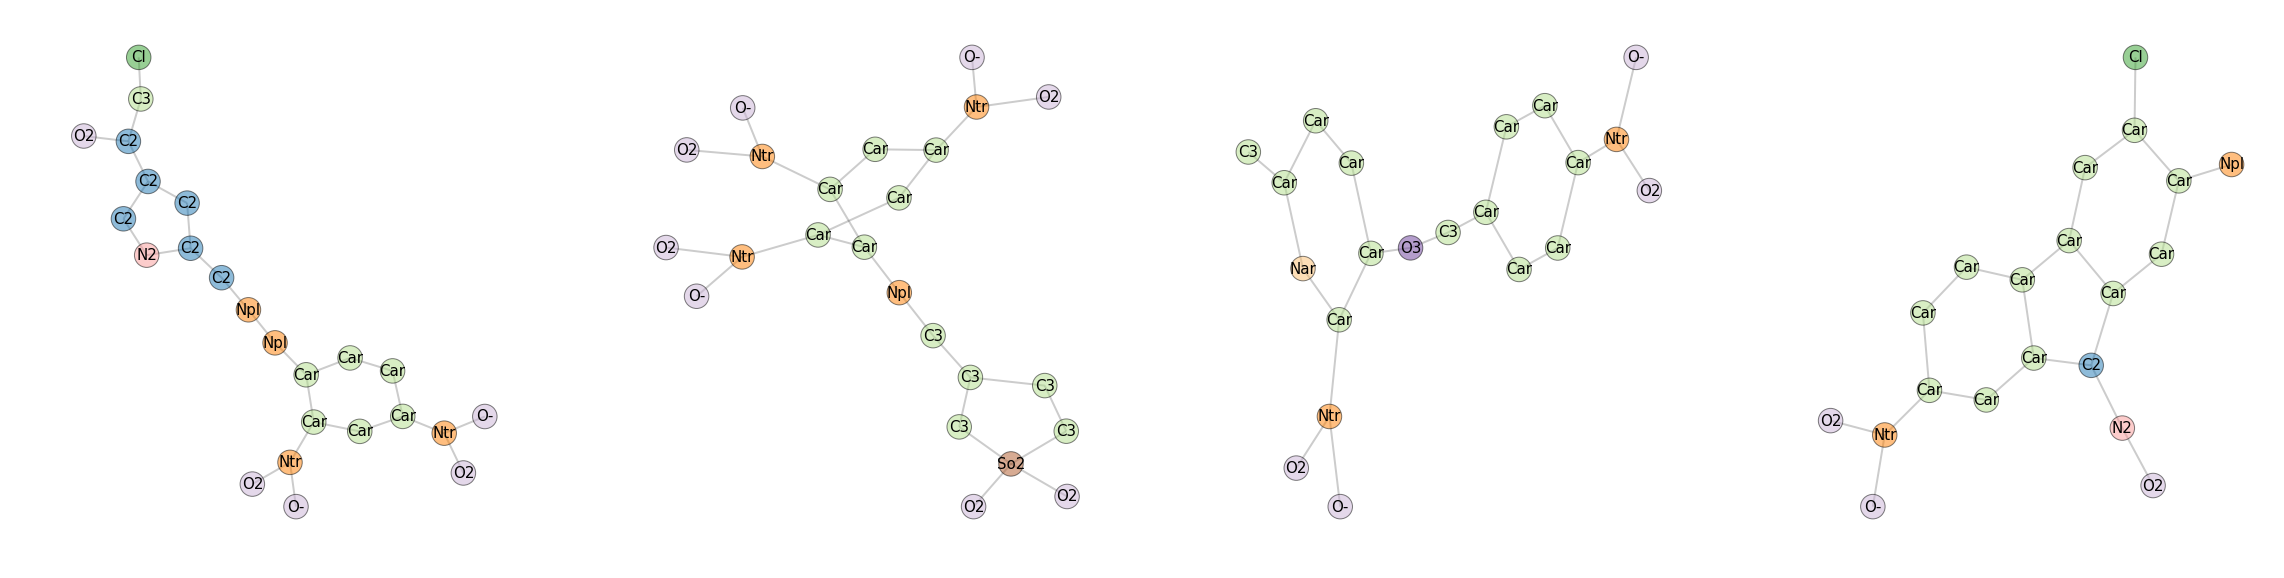

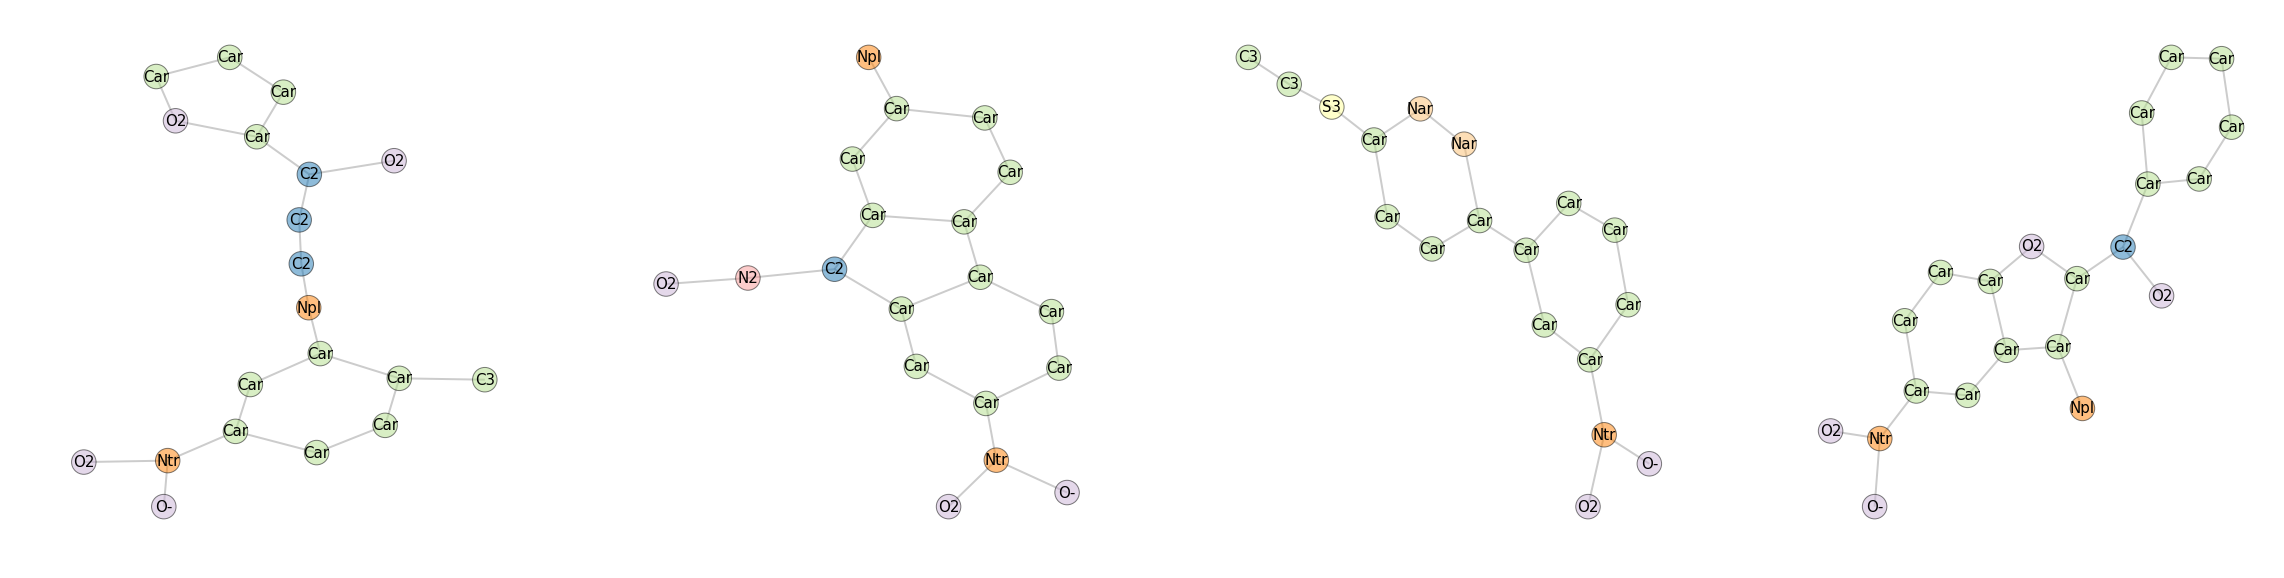

CPU times: user 16.2 s, sys: 1.32 s, total: 17.5 s
Wall time: 21.3 s



In [104]:
%%time

graphs = get_graphs()
base_graph = graphs[0]
from eden.display import draw_graph, map_labels_to_colors
label_colors = map_labels_to_colors(graphs)
draw_graph(base_graph, colormap='Paired', size=5,
           vertex_color='_labels_', vertex_color_dict=label_colors,layout='KK')


n_neighbors = 8
from sklearn.neighbors import NearestNeighbors
X = vec.transform(graphs)
nbrs = NearestNeighbors(n_neighbors=n_neighbors+1).fit(X)
base_x = vec.transform([base_graph])
distances, indices = nbrs.kneighbors(base_x)

neighbor_graphs = [graphs[i] for i in list(indices[0])[1:]]
desired_distances = distances[0][1:]
reference_vecs = vec.transform(neighbor_graphs)

for i,d in zip(list(indices[0]), list(distances[0]))[1:]:
    print('id:%d (%.2f)'%(i,d)), 
from graphlearn.utils import draw
draw.graphlearn(neighbor_graphs,contract=True,#vertex_label='id',
                n_graphs_per_line=4, size=10, 
                colormap='Paired', invert_colormap=False, vertex_color='_labels_', 
                vertex_color_dict=label_colors,
                vertex_alpha=0.5, edge_alpha=0.2) 

In [105]:
VC = VecComparator(reference_vecs, desired_distances)

### set up a sampler (default parameters shown) with the new scoring system

In [106]:
from graphlearn.graphlearn import  Sampler
from eden.graph import Vectorizer
from graphlearn.utils.neighbors import graph_neighbors

class DirectSampler(Sampler):
    def _choose_proposal(self,graph_decomposer):
        grammar = self.lsgg
        neighbors = list(graph_neighbors(graph_decomposer, grammar, self.graph_transformer))
        max_score, max_graph = max(map(lambda g:(self._score(g),g), neighbors))
        if self._score(graph_decomposer) < max_score:
            return max_graph
        else:
            return graph_decomposer

In [107]:
%%time
from graphlearn.localsubstitutablegraphgrammar import LocalSubstitutableGraphGrammar
from eden.graph import Vectorizer

sampler=DirectSampler(estimator = VC,
                      vectorizer = vec,
                 grammar=LocalSubstitutableGraphGrammar(radius_list=[0,1,2,3],
                                                        thickness_list=[1],
                                                        min_cip_count=5,
                                                        min_interface_count=5), 
                 core_choice_byfrequency=False,
                 core_choice_byscore=False,
                 core_choice_bytrial=False,
                 core_choice_bytrial_multiplier=1.0,
                 size_diff_core_filter=-1,
                 size_constrained_core_choice=-1,
                 similarity=-1,
                 n_samples=5,
                 proposal_probability=False,
                 batch_size=10,
                 n_jobs=1,

                 orig_cip_max_positives=1,
                 orig_cip_min_positives=0,

                 n_steps=10,
                 quick_skip_orig_cip=False,
                 improving_threshold_fraction=-1,
                 improving_linear_start_fraction=0,
                 accept_static_penalty=0.0,
                 accept_min_similarity=0.0,
                 select_cip_max_tries=20,
                 burnin=0,
                 backtrack=0,

                 include_seed=True,
                 keep_duplicates=False,

                 monitor=True,
                 proposed_graphs_per_step=1
               )

CPU times: user 45.2 ms, sys: 46.8 ms, total: 92 ms
Wall time: 92 ms


In [108]:
%%time
# get training graphs
training_graphs = get_graphs()
sampler.fit(training_graphs)

# lets look at a few stats about the trained sampler
print('graph grammar stats:')
n_instances, interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#instances: %d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (n_instances, interface_counts, core_counts, cip_counts))

graph grammar stats:
#instances: 1232   #interfaces: 132   #cores: 759   #core-interface-pairs: 1669
CPU times: user 41.5 s, sys: 3.7 s, total: 45.2 s
Wall time: 51.2 s


# Sample and show generated graphs

Graph id: 0


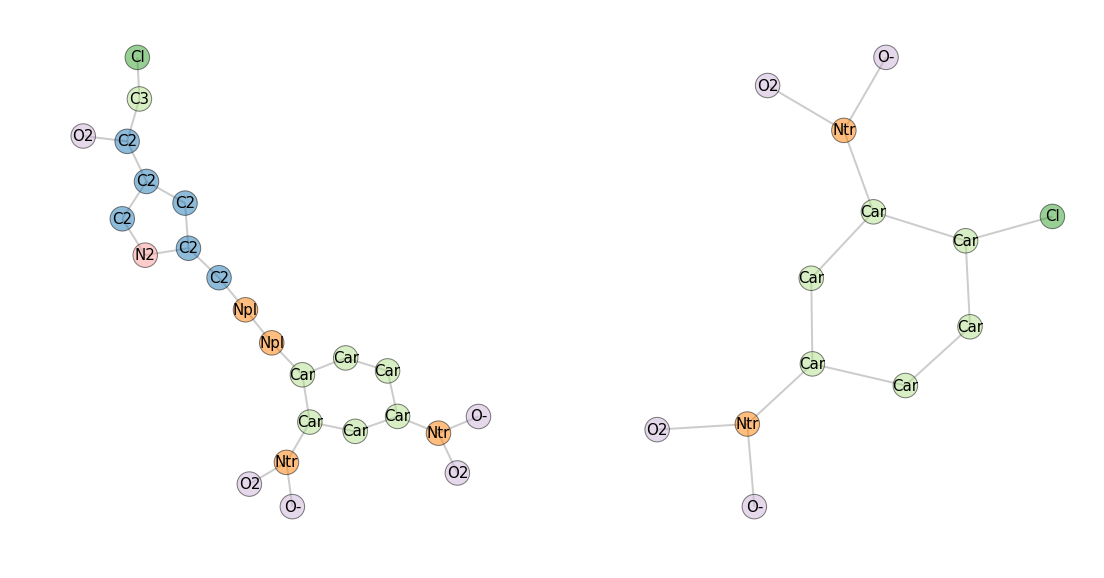

Graph id: 1


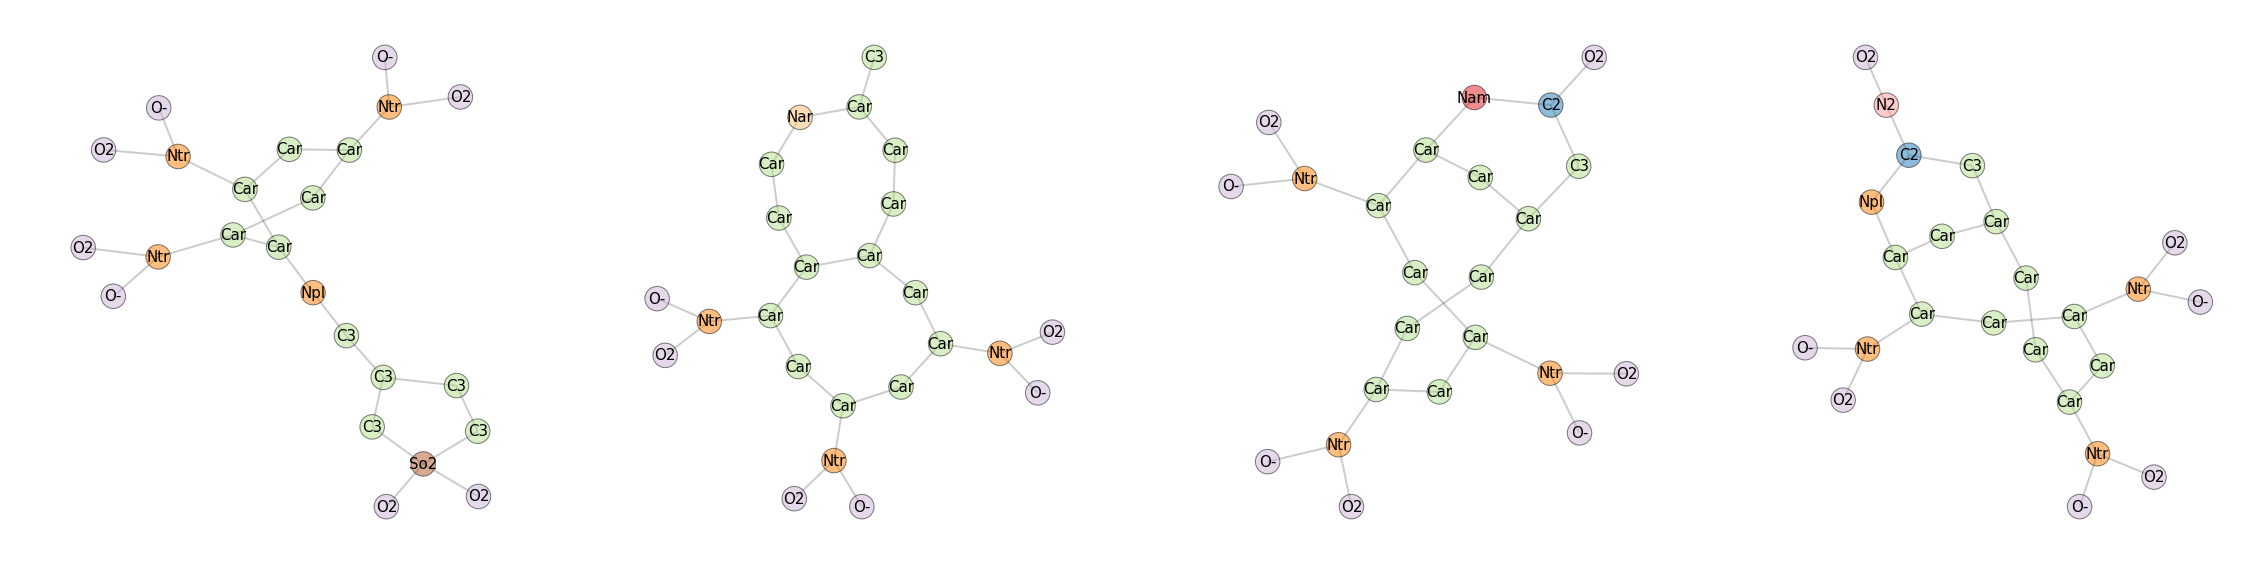

Graph id: 2


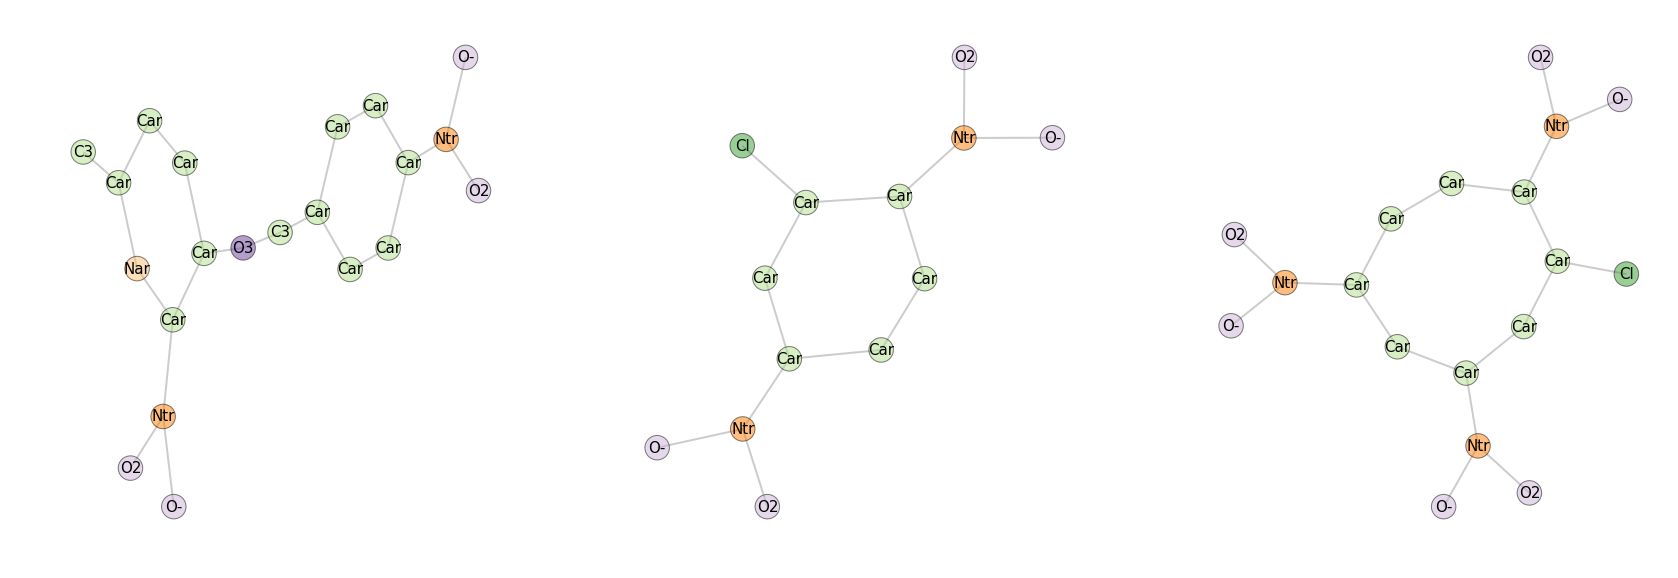

Graph id: 3


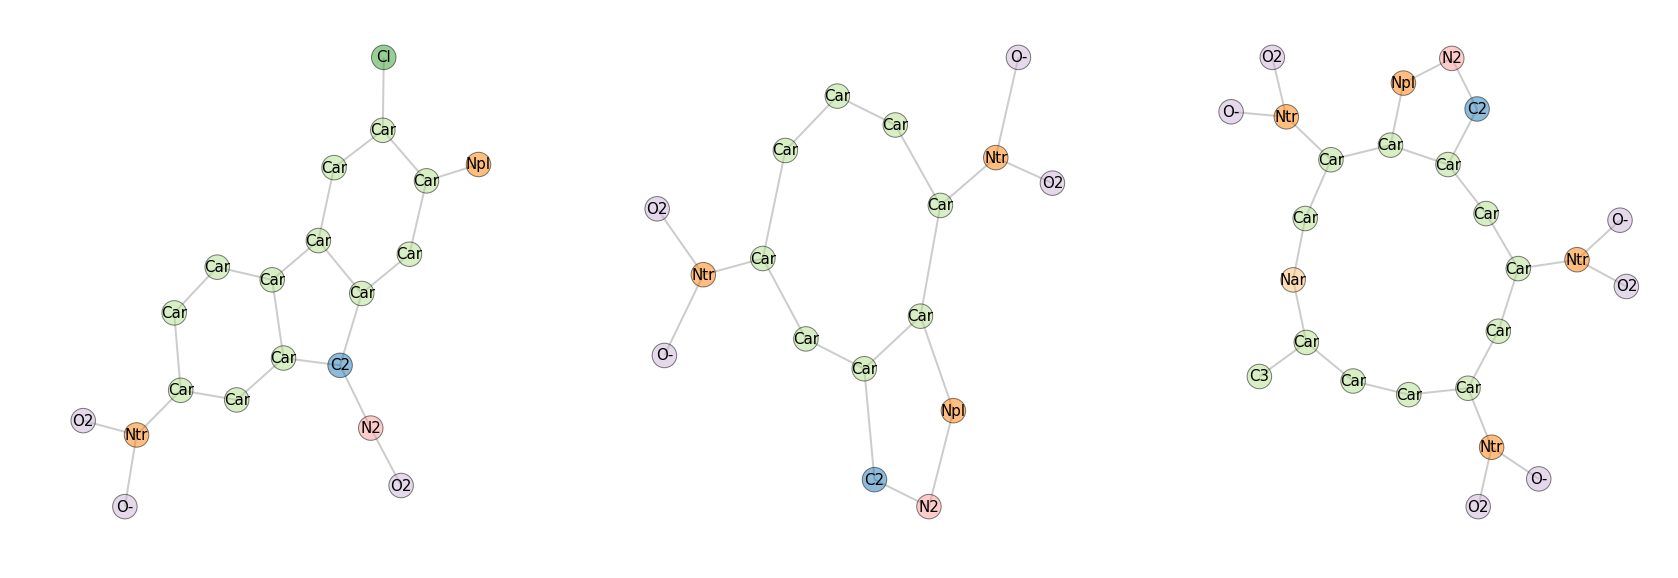

Graph id: 4


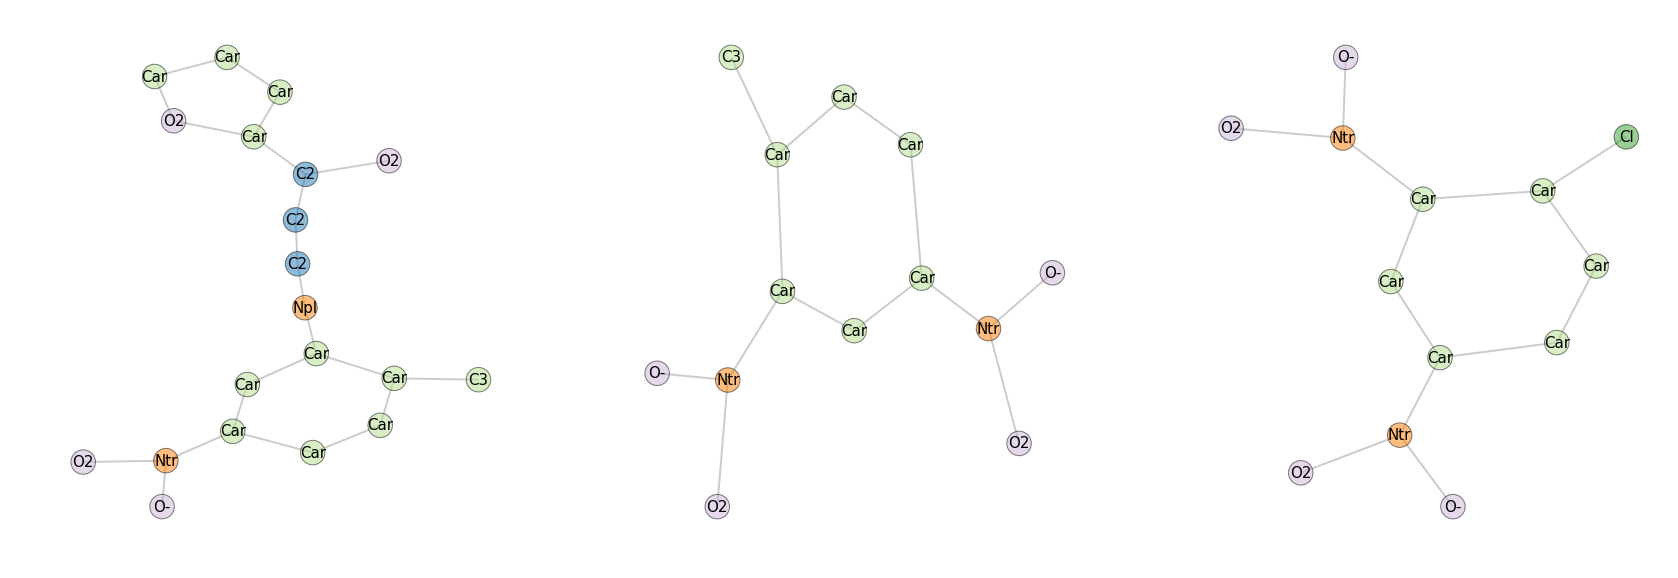

Graph id: 5


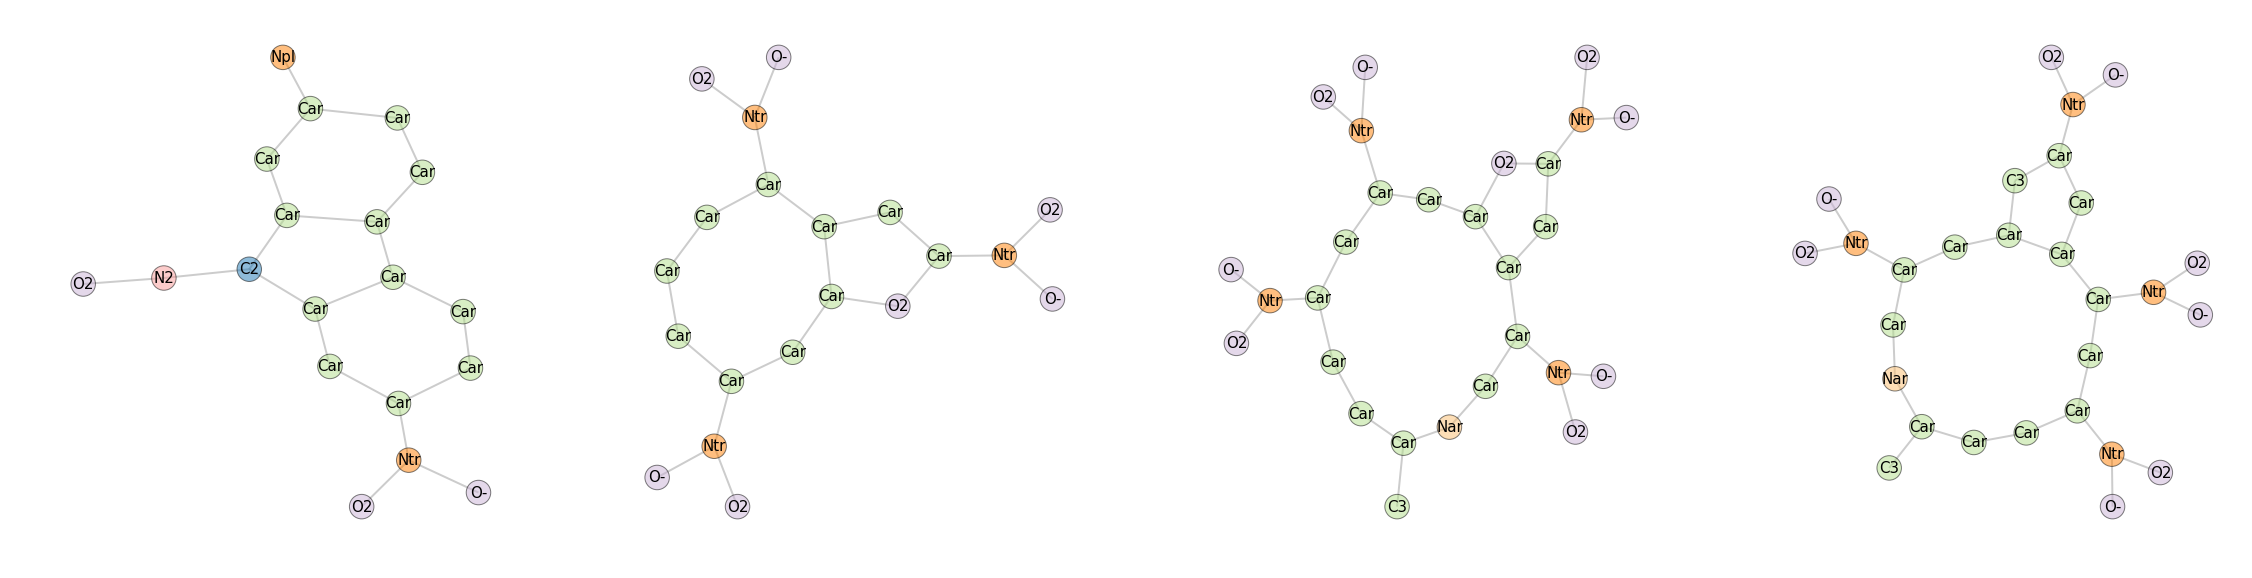

Graph id: 6


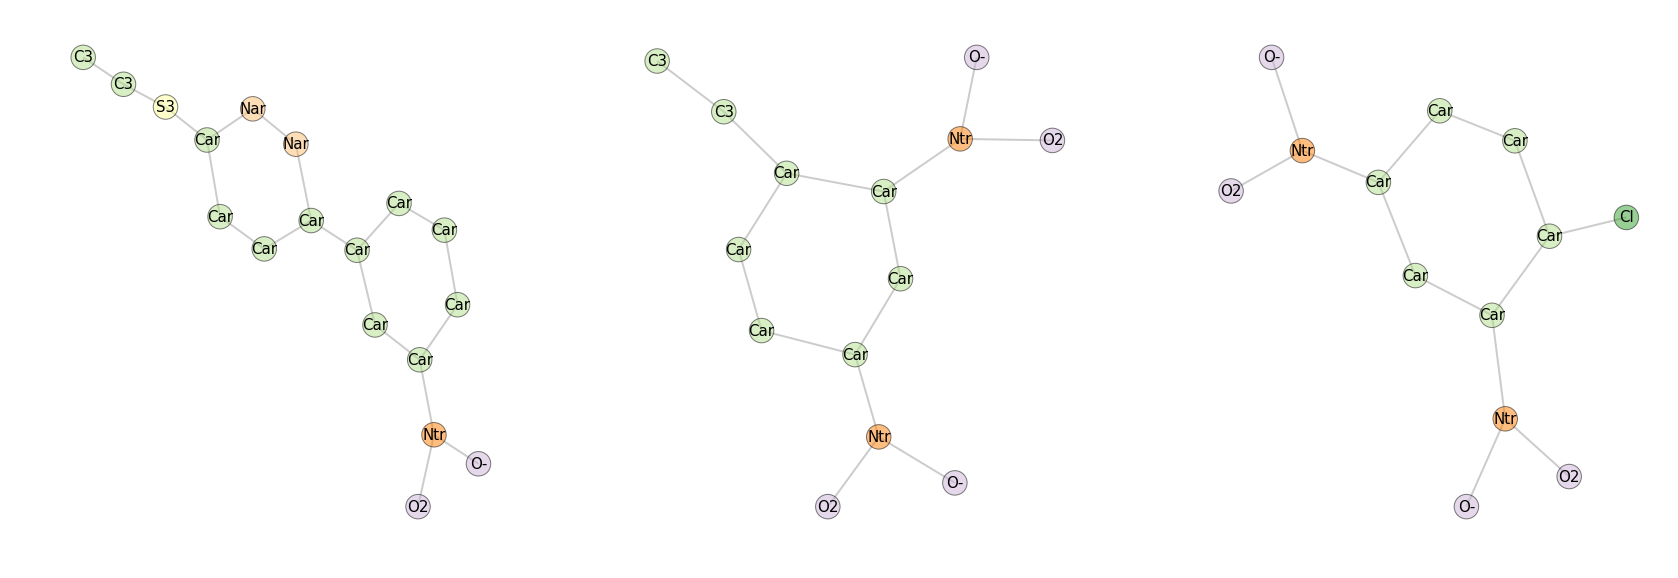

Graph id: 7


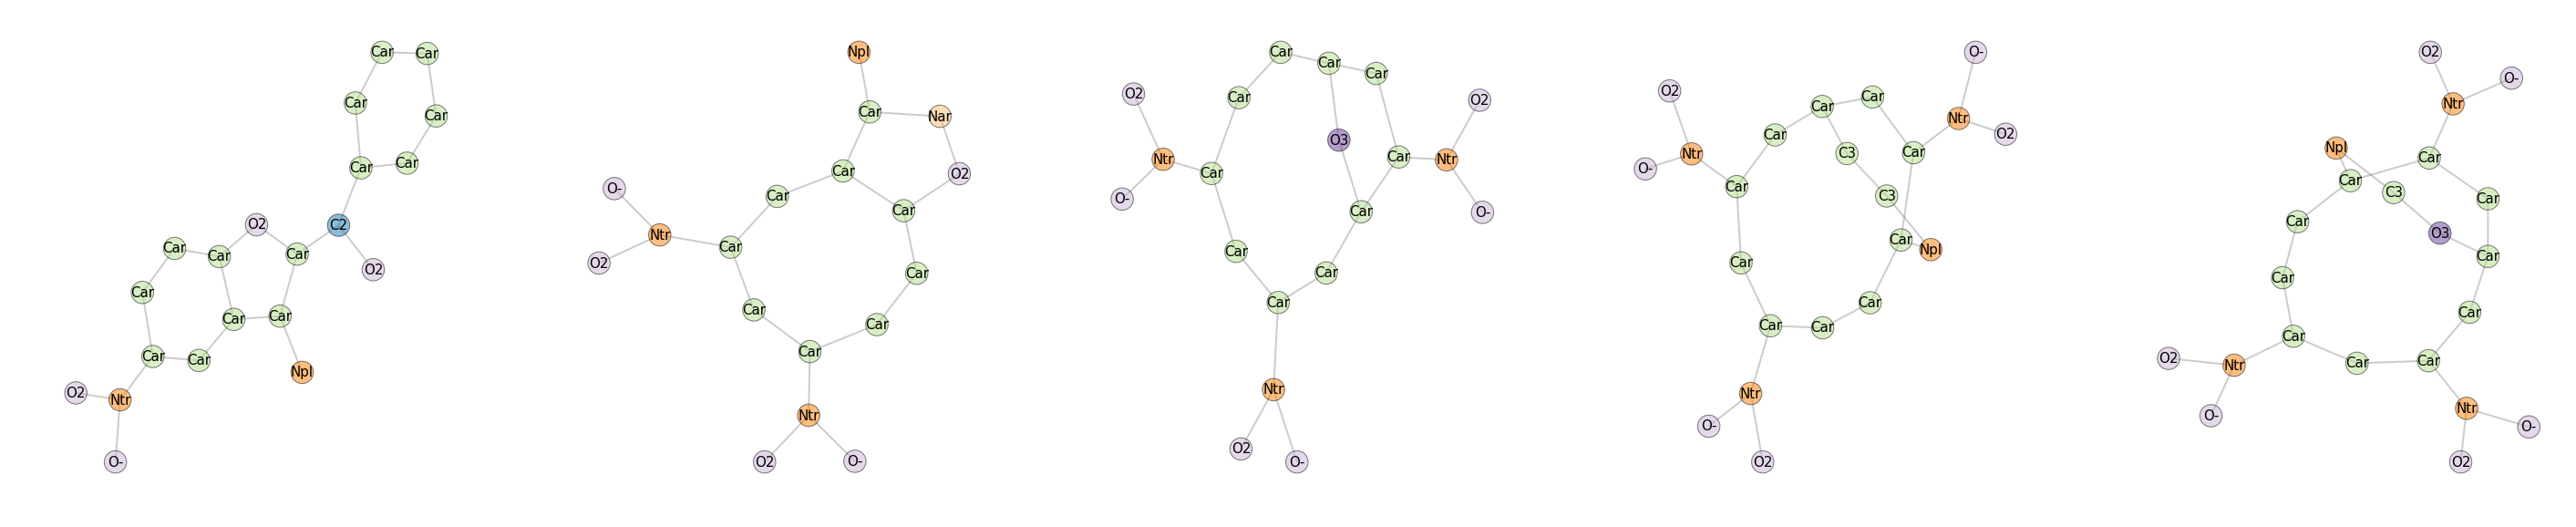

CPU times: user 24min 16s, sys: 55 s, total: 25min 11s
Wall time: 24min 50s


In [109]:
%%time
# plot examples of sampling paths
sample_graphs = sampler.transform(neighbor_graphs)

scores=[]
for i,graphlist in enumerate(sample_graphs):
    print 'Graph id: %d'%(i)
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    if BABELDRAW:
        from graphlearn.utils import openbabel
        openbabel.draw(graphlist, d3=False, n_graphs_per_line=6,size=200)
    else:
        from graphlearn.utils import draw
        draw.graphlearn(graphlist,contract=True,#vertex_label='id',
                        n_graphs_per_line=6, size=10,
                        colormap='Paired', invert_colormap=False, vertex_color='_labels_', vertex_color_dict=label_colors,
                        vertex_alpha=0.5, edge_alpha=0.2) 

# Show sample score history

2


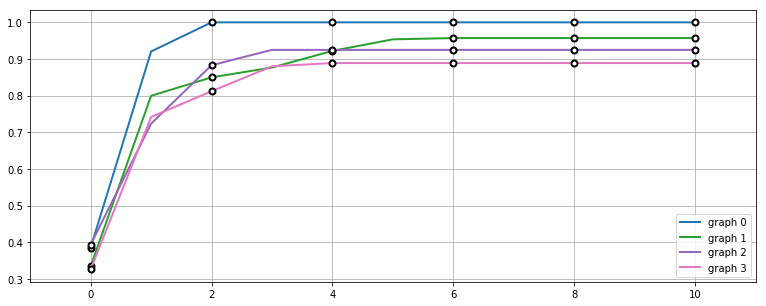

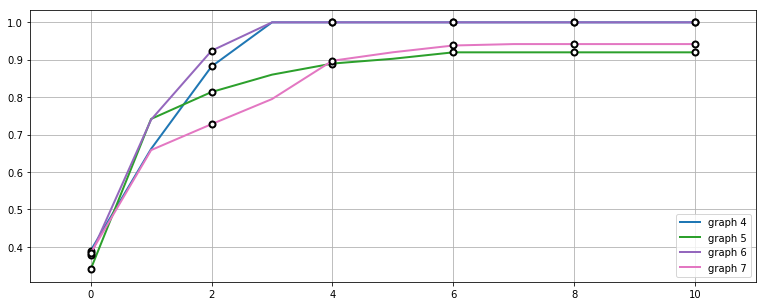

CPU times: user 488 ms, sys: 21.2 ms, total: 509 ms
Wall time: 500 ms


In [110]:
%%time
# plot sampling path score
n_steps=sampler.n_steps
n_samples= sampler.n_samples


from itertools import islice
import numpy as np
import pylab as plt
markevery=  n_steps/(n_samples) if n_samples else 10
step=1
num_graphs_per_plot=4

import math
num_plots= int(math.ceil(len(scores)/float(num_graphs_per_plot)))
print num_plots
for i in range(num_plots):
    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot))
        plt.plot(data, linestyle='None',markevery=markevery, markerfacecolor='white', markeredgecolor='k', marker='o', markeredgewidth=2,markersize=6)
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,n_steps+1)
    #plt.ylim(-0.1,1.1)
    plt.show()

---